# MODELO DE CLASIFICACIÓN CON RANDOM FOREST


# LIBRERIAS 

In [2]:
# Tratamiento de datos

import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8

# Preprocesado y modelado

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed
import optuna

# Configuración warnings

import warnings

# Datos
El set de datos Carseats, original del paquete de R ISLR y accesible en Python a través de statsmodels.datasets.get_rdataset, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables. Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.

In [4]:
# Lectura de datos

carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
datos.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Como Sales es una variable continua y el objetivo del estudio es clasificar las tiendas según si venden mucho o poco, se crea una nueva variable binaria (0, 1) llamada ventas_altas.

In [5]:
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

# Ajuste del modelo y optimización de hiperparámetros

Se ajusta un árbol de clasificación empleando como variable respuesta ventas_altas y como predictores todas las variables disponibles. Se utilizan en primer lugar los hiperparámetros max_depth=5 y criterion='gini', el resto se dejan por defecto. Después, se aplica el proceso de pruning y se comparan los resultados frente al modelo inicial.

A diferencia del ejemplo anterior, en estos datos hay variables categóricas por lo que, antes de entrenar el modelo, es necesario aplicar one-hot-encoding.

In [6]:
# División de los datos en train y test

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), cat_cols)],
                    remainder='passthrough',
                    verbose_feature_names_out=False
               ).set_output(transform="pandas")

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [7]:
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 170 to 365
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ShelveLoc_Bad     300 non-null    float64
 1   ShelveLoc_Good    300 non-null    float64
 2   ShelveLoc_Medium  300 non-null    float64
 3   Urban_Yes         300 non-null    float64
 4   US_Yes            300 non-null    float64
 5   CompPrice         300 non-null    int64  
 6   Income            300 non-null    int64  
 7   Advertising       300 non-null    int64  
 8   Population        300 non-null    int64  
 9   Price             300 non-null    int64  
 10  Age               300 non-null    int64  
 11  Education         300 non-null    int64  
dtypes: float64(5), int64(7)
memory usage: 30.5 KB


Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test

# Grid Search basado en out-of-bag score

In [12]:
# Grid de hiperparámetros evaluados

param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros

resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train_prep, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns='params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
22,0.820000,entropy,20.0,7,150
13,0.820000,entropy,NaN,7,150
0,0.813333,gini,NaN,5,150
9,0.813333,gini,20.0,5,150


In [9]:
# Mejores hiperparámetros por out-of-bag error

print("==================================================")
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print("==================================================")
print(resultados.iloc[0,0:])

Mejores hiperparámetros encontrados (oob-accuracy)
oob_accuracy       0.82
criterion       entropy
max_depth          20.0
max_features          7
n_estimators        150
Name: 22, dtype: object


# Grid Search basado en validacion cruzada

In [13]:
# Grid de hiperparámetros evaluados

param_grid = {
    'n_estimators': [150],
    'max_features': [5, 7, 9],
    'max_depth'   : [None, 3, 10, 20],
    'criterion'   : ['gini', 'entropy']
}

# Búsqueda por grid search con validación cruzada

grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X=X_train_prep, y=y_train)

# Resultados

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex='(param*|mean_t|std_t)') \
    .drop(columns='params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
12,entropy,None,5,150,0.817778,0.028846,1.0,0.0
21,entropy,20,5,150,0.817778,0.028846,1.0,0.0
18,entropy,10,5,150,0.814444,0.030952,1.0,0.0
22,entropy,20,7,150,0.812222,0.027532,1.0,0.0


n_jobs     = cpu_count() - 1, se podria agregar en en busqueda por GRID con validacion agregada

In [15]:
# Mejores hiperparámetros encontrados por validación cruzada

print("============================================")
print("Mejores hiperparámetros encontrados por (cv)")
print("============================================")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

Mejores hiperparámetros encontrados por (cv)
{'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} : 0.8177777777777779 accuracy


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.


# Predicción y evaluación del modelo

Por último, se evalúa la capacidad predictiva del modelo final empleando el conjunto de test.

In [16]:
# Modelo con los mejores hiperparámetros

modelo_final = grid.best_estimator_
modelo_final

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=150,
                       random_state=123)

In [17]:
# Error de test del modelo final

predicciones = modelo_final.predict(X=X_test_prep)
predicciones[:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

Matriz de confusión
-------------------
[[33 17]
 [ 3 47]]

El accuracy de test es: 80.0 % 

              precision    recall  f1-score   support

           0       0.92      0.66      0.77        50
           1       0.73      0.94      0.82        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



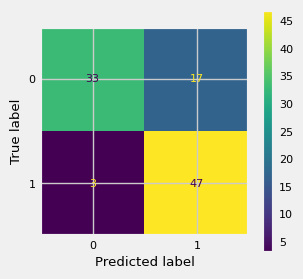

In [18]:
mat_confusion = confusion_matrix(y_true=y_test, y_pred=predicciones)
accuracy = accuracy_score(y_true=y_test, y_pred=predicciones, normalize=True)
print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} % \n")
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay(mat_confusion).plot(ax=ax)

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

Tras optimizar los hiperparámetros, se consigue un porcentaje de acierto del 78%.

# Predicción de probabilidades
La mayoría de implementaciones de Random Forest, entre ellas la de scikit-learn, permiten predecir probabilidades cuando se trata de problemas de clasificación. Es importante entender cómo se calculan estos valores para interpretarlos y utilizarlos correctamente.

En el ejemplo anterior, al aplicar .predict() se devuelve  1 (ventas elevadas) o  0 (ventas bajas) para cada observación de test. Sin embargo, no se dispone de ningún tipo de información sobre la seguridad con la que el modelo realiza esta asignación. Con .predict_proba(), en lugar de una clasificación, se obtiene la probabilidad con la que el modelo considera que cada observación puede pertenecer a cada una de las clases.

In [19]:
# Predicción de probabilidades

predicciones = modelo_final.predict_proba(X=X_test_prep)
predicciones[:5, :]

array([[0.78666667, 0.21333333],
       [0.72      , 0.28      ],
       [0.86      , 0.14      ],
       [0.72666667, 0.27333333],
       [0.79333333, 0.20666667]])

El resultado de .predict_proba() es un array con una fila por observación y tantas columnas como clases tenga la variable respuesta. El valor de la primera columna se corresponde con la probabilidad, acorde al modelo, de que la observación pertenezca a la clase 0, y así sucesivamente. El valor de probabilidad mostrado para cada predicción se corresponde con la fracción de observaciones de cada clase en los nodos terminales a los que ha llegado la observación predicha en el conjunto de los árboles.

Por defecto, .predict() asigna cada nueva observación a la clase con mayor probabilidad (en caso de empate se asigna de forma aleatoria). Sin embargo, este no tiene por qué ser el comportamiento deseado en todos los casos.

In [20]:
# Clasificación empleando la clase de mayor probabilidad

df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

,0,1,clasificacion_default_0.5
0,0.786667,0.213333,0
1,0.720000,0.280000,0
2,0.860000,0.140000,0


Supóngase el siguiente escenario: la campaña de navidad se aproxima y los propietarios de la cadena quieren duplicar el stock de artículos en aquellas tiendas de las que se preve que tengan ventas elevadas. Como el transporte de este material hasta las tiendas supone un coste elevado, el director quiere limitar esta estrategia únicamente a tiendas para las que se tenga mucha seguridad de que van conseguir muchas ventas.

Si se dispone de las probabilidades, se puede establecer un punto de corte concreto, por ejemplo, considerando únicamente como clase  1  (ventas altas) aquellas tiendas cuya predicción para esta clase sea superior al 0.9 (90%). De esta forma, la clasificación final se ajusta mejor a las necesidades del caso de uso.

In [21]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.

df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.9, 1, 0)
df_predicciones.iloc[4:10, :]

,0,1,clasificacion_default_0.5,clasificacion_custom_0.8
4,0.793333,0.206667,0,0
5,0.606667,0.393333,0,0
6,0.186667,0.813333,1,0
7,0.360000,0.640000,1,0
8,0.126667,0.873333,1,0
9,0.160000,0.840000,1,0


# ¿Hasta que punto se debe de confiar en estas probabilidades?

Es muy importante tener en cuenta la diferencia entre la "visión" que tiene el modelo del mundo y el mundo real. Todo lo que sabe un modelo sobre el mundo real es lo que ha podido aprender de los datos de entrenamiento y, por lo tanto, tiene una "visión" limitada. Por ejemplo, supóngase que, en los datos de entrenamiento, todas las tiendas que están en zona urbana Urban='Yes' tienen ventas altas independientemente del valor que tomen el resto de predictores. Cuando el modelo trate de predecir una nueva observación, si esta está en zona urbana, clasificará a la tienda como ventas elevadas con un 100% de seguridad. Sin embargo, esto no significa que sea inequivocamente cierto, podría haber tiendas en zonas úrbanas que no tienen ventas elevadas pero, al no estar presentes en los datos de entrenamiento, el modelo no contempla esta posibilidad.

Teniendo en cuenta todo esto, hay que considerar las probabilidades generadas por el modelo como la seguridad que tiene este, desde su visión limitada, al realizar las predicciones. Pero no como la probailidad en el mundo real de que así lo sea.

# Importancia de predictores
## Importancia por pureza de nodos

In [22]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train_prep.columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
9,Price,0.221835
5,CompPrice,0.115144
7,Advertising,0.114074
10,Age,0.100719
6,Income,0.097072
1,ShelveLoc_Good,0.086468
8,Population,0.074825
0,ShelveLoc_Bad,0.062682
11,Education,0.062288
2,ShelveLoc_Medium,0.027956


# Importancia por permutación

In [24]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train_prep,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                random_state = 123,
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train_prep.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
9,0.450240,0.024852,Price
1,0.343318,0.011515,ShelveLoc_Good
7,0.294198,0.010686,Advertising
5,0.258743,0.019633,CompPrice
0,0.253407,0.021248,ShelveLoc_Bad
10,0.174773,0.011008,Age
6,0.138299,0.014376,Income
8,0.072084,0.011716,Population
11,0.060537,0.031654,Education
4,0.034641,0.028284,US_Yes


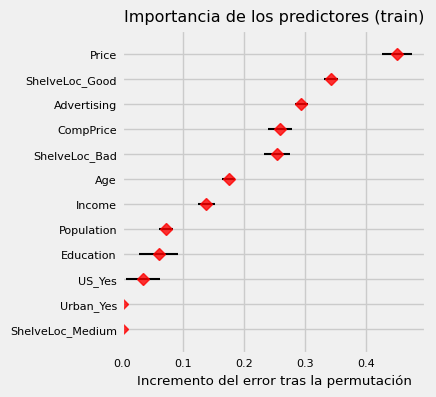

In [25]:
# Gráfico

fig, ax = plt.subplots(figsize=(3.5, 4))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

Ambas estrategias identifican Price, Advertising y ShelveLoc como los predictores más influyentes, acorde a los datos de entrenamiento.

# Biblografiía:

Random Forest con Python por Joaquín Amat Rodrigo, disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py08_random_forest_python.html